In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Unsupervised Learning with Autoencoders

1. Clustering with k-means
2. Clustering in  'pixel' space
3. Training an auto-encoder
4. Clustering in 'latent' space
   




# Load MNIST

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomAffine(10, translate=(.1,.1), scale=(0.8,1.2)),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f"Image shape: {images.shape}")


Image shape: torch.Size([64, 1, 28, 28])


# To use some of our other tools let's read out all of our batches

In [3]:
mnist_images =[]
mnist_labels =[]
for images, labels in testloader:
    mnist_images.append(images)
    mnist_labels.append(labels)

# Concatenate all the images and labels
mnist_images = torch.cat(mnist_images, dim=0)
mnist_labels = torch.cat(mnist_labels, dim=0)

# 2. Flatten MNIST and Cluster with K-Means (Pixel Space)

## These clustering methods are normally considered 'traditional ml', but we can still use them.
 K-Means find centroids that best cluster the data
 ![Clustering Example](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)


In [4]:
flattened_images = mnist_images.view(mnist_images.shape[0], -1).numpy()
kmeans_pixel = KMeans(n_clusters=10, random_state=42,n_init='auto')
cluster_labels_pixel = kmeans_pixel.fit_predict(flattened_images)
print(f"Pixel space cluster labels: {cluster_labels_pixel}")


Pixel space cluster labels: [5 9 4 ... 3 0 2]


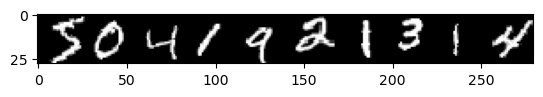

In [5]:
plt.imshow(np.hstack(mnist_images[0:10,0,:,:]),cmap='gray')


# Let's plot our cluster centorids

Cluster Centroid


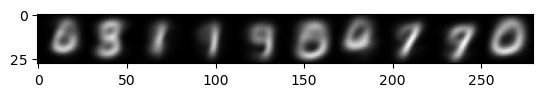

In [6]:
print('Cluster Centroid')
plt.imshow(np.hstack(kmeans_pixel.cluster_centers_.reshape(10,28,28)),cmap='gray')
plt.show()



# Autoencoder Excerise
Now let's try to find a latent space with an autoencoder. I've provides most of the code below. However, I would like you to:

1. Write an encoder that takes a 28x28x1 images and uses a CNN to down-size and flatten that to (batch_size x latent dim ) vector just like we were writing a classifier. 

![example](https://charliegoldstraw.com/articles/autoencoder/assets/autoencoder.webp)

2. Then run the training loop and evaluation in the cells below



In [7]:
# 4. Train an Autoencoder on MNIST
class CNNAutoencoder(nn.Module):
    def __init__(self,latent_dim=2):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # -> 32x7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,128),
            nn.ReLU(),
            nn.Linear(128, 32 * 7 * 7),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # -> 28x28
            nn.Tanh()
        )

    def forward(self, x):
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x,latent

latent_dim=16
weight_decay=1e-4
lr=1e-3
l1_reg=1e-1
autoencoder = CNNAutoencoder(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(),weight_decay=weight_decay, lr=lr)

In [8]:


epochs = 10
for epoch in range(epochs):
    for data in trainloader:
        img, _ = data
        optimizer.zero_grad()
        output,latent = autoencoder(img.to(device))
        loss = criterion(output, img.to(device))+latent.abs().mean()*l1_reg
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f} Reg:{l1_reg}')
print('Autoencoder training finished.')


Epoch [1/10], Loss: 0.1230 Reg:0.1
Epoch [2/10], Loss: 0.1297 Reg:0.1
Epoch [3/10], Loss: 0.0892 Reg:0.1
Epoch [4/10], Loss: 0.0949 Reg:0.1
Epoch [5/10], Loss: 0.0932 Reg:0.1
Epoch [6/10], Loss: 0.0858 Reg:0.1
Epoch [7/10], Loss: 0.0927 Reg:0.1
Epoch [8/10], Loss: 0.0986 Reg:0.1
Epoch [9/10], Loss: 0.0858 Reg:0.1
Epoch [10/10], Loss: 0.0745 Reg:0.1
Autoencoder training finished.


In [9]:
# Encode our dataset

latent_representations = []
ae_labels=[]
with torch.no_grad():
    latent = autoencoder.encoder(mnist_images.to(device))

In [10]:
print(latent.shape)

torch.Size([60000, 16])


# Latent spaces can be reconstructed to see how well the model is working

In [11]:
with torch.no_grad():
    reco=autoencoder.decoder(latent[0:10].to(device)).cpu().numpy()

True


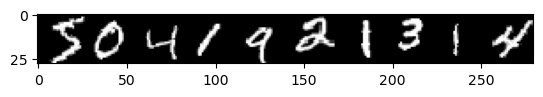

Recontructions


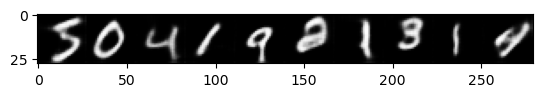

In [12]:
print('True')
plt.imshow(np.hstack(mnist_images[0:10].squeeze()),cmap='gray')
plt.show()
print('Recontructions')
plt.imshow(np.hstack(reco.squeeze()),cmap='gray')
plt.show()

In [13]:
kmeans_latent = KMeans(n_clusters=10, random_state=42,n_init='auto')
cluster_labels_latent = kmeans_latent.fit_predict(latent.cpu().numpy())
print(f"Latent space cluster labels: {cluster_labels_latent}")


Latent space cluster labels: [0 4 1 ... 5 6 5]


# Plot our cluster Centroids

In [14]:
with torch.no_grad():
    centroid_reco=autoencoder.decoder(torch.tensor(kmeans_latent.cluster_centers_).to(device)).squeeze().cpu().numpy()


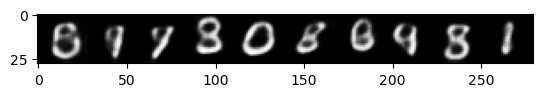

In [15]:
plt.imshow(np.hstack(centroid_reco),cmap='gray')

Text(0, 0.5, 'True Labels')

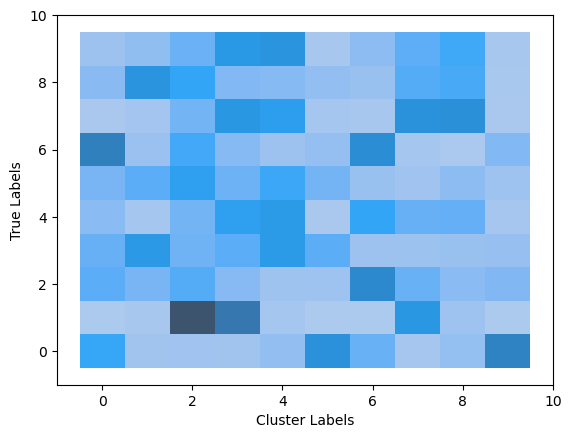

In [16]:
sns.histplot(x=cluster_labels_pixel,y=mnist_labels,discrete=True)
plt.xlabel('Cluster Labels')
plt.ylabel('True Labels')

# Generation

Try creating a new 'number'

1. Create a new tensor that's the 1xlatent dim
2. use the autoencoder to generate a new image


In [17]:
print(latent.mean(axis=0))

tensor([-0.0086, -0.0028,  0.0035,  0.0058,  0.0105,  0.0105,  0.0088, -0.0058,
         0.0099, -0.0016,  0.0045,  0.0004, -0.0006,  0.0043,  0.0005, -0.0010],
       device='cuda:0')


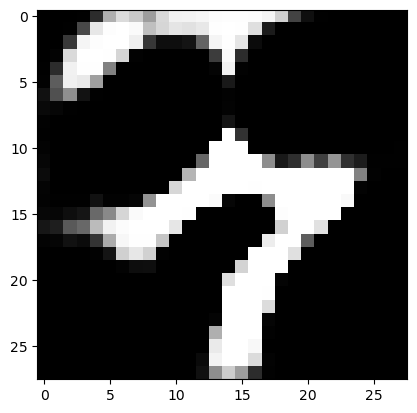

In [18]:
with torch.no_grad():
    scale=1
    out=autoencoder.decoder((torch.randn(size=(1,latent_dim))*scale).to(device)).cpu().squeeze().numpy()
plt.imshow(out,cmap='gray')
plt.show()    

## Why do our reconsturctions look good, but our randomly generatered images are weird?

Our latent space still lives on it's own manifold with various correlations

correlations


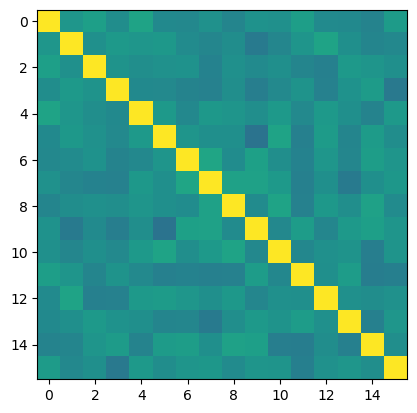

In [19]:
print('correlations')
plt.imshow(np.corrcoef(latent.cpu().numpy().T),vmin=-1,vmax=1)

## Compare clusters and labels

Text(0, 0.5, 'True Labels')

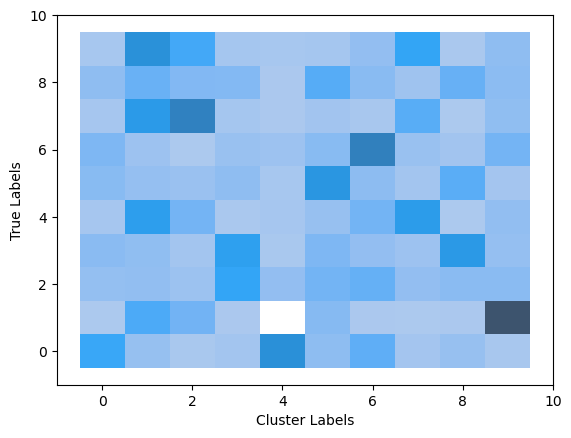

In [20]:
sns.histplot(x=cluster_labels_latent,y=mnist_labels,discrete=True)
plt.xlabel('Cluster Labels')
plt.ylabel('True Labels')



# TSNE
* Dimensionality Reduction: t-SNE (t-Distributed Stochastic Neighbor Embedding) is a technique primarily used for dimensionality reduction. It excels at taking high-dimensional data (like images with many pixels) and representing it in a lower-dimensional space, typically 2D or 3D, while preserving the relationships between data points.

* Visualization: Its main purpose is visualization. By reducing data to 2D or 3D, we can plot it and gain insights into its structure, clusters, and patterns that would be difficult to discern in the original high-dimensional space.

* Neighbor Preservation: t-SNE focuses on preserving the local neighborhood structure of the data. Points that are close together in the high-dimensional space will also tend to be close together in the low-dimensional representation.


* Non-linearity: Unlike linear dimensionality reduction techniques like PCA, t-SNE can capture non-linear relationships in the data. This makes it suitable for complex datasets where the structure isn't easily captured by linear projections.

* Stochasticity: t-SNE involves a degree of randomness, meaning that running it multiple times on the same data might produce slightly different results. It's often recommended to run t-SNE with different parameters and random seeds to explore the stability of the embedding.

In [21]:
# Visualize t-SNE of the latent space after k-means
tsne_ae = TSNE(n_components=2, random_state=42)
tsne_ae_results = tsne_ae.fit_transform(latent.cpu().numpy())


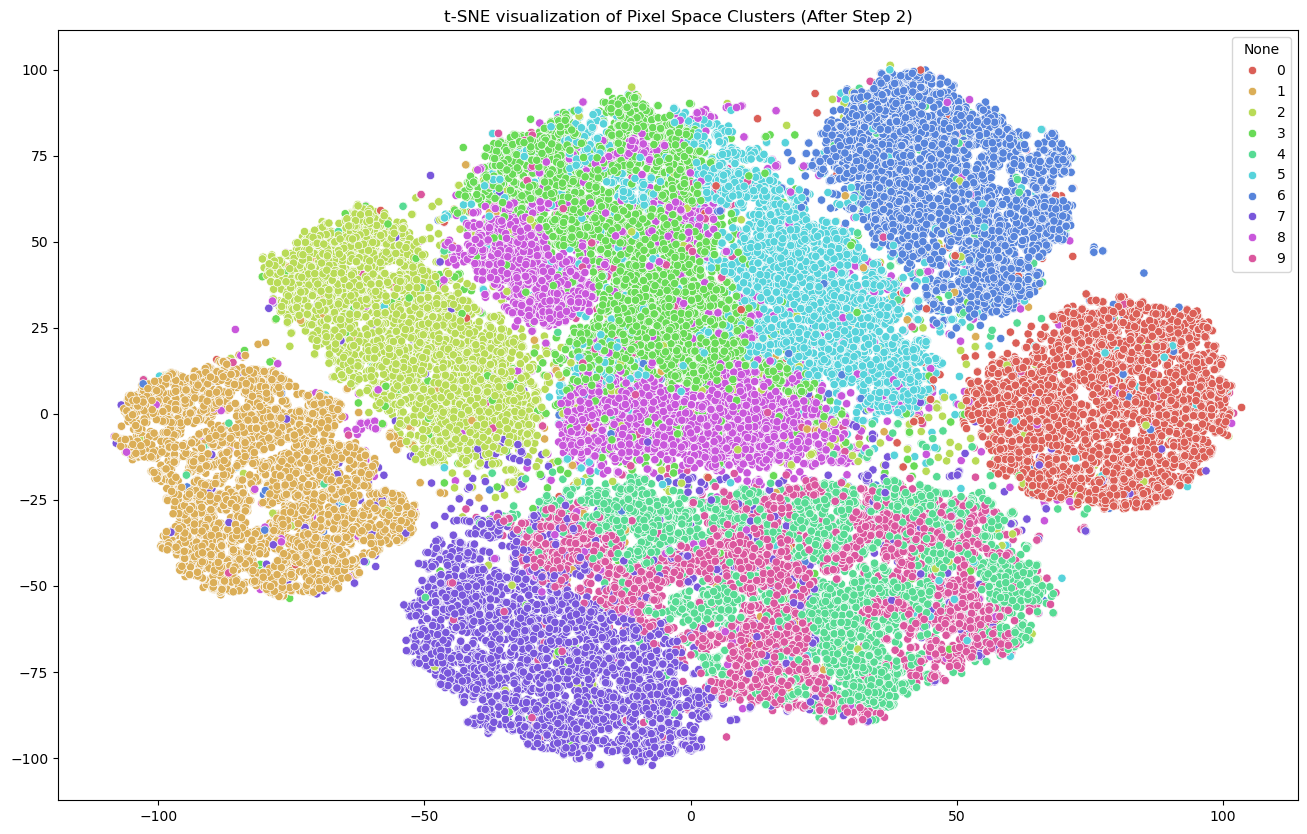

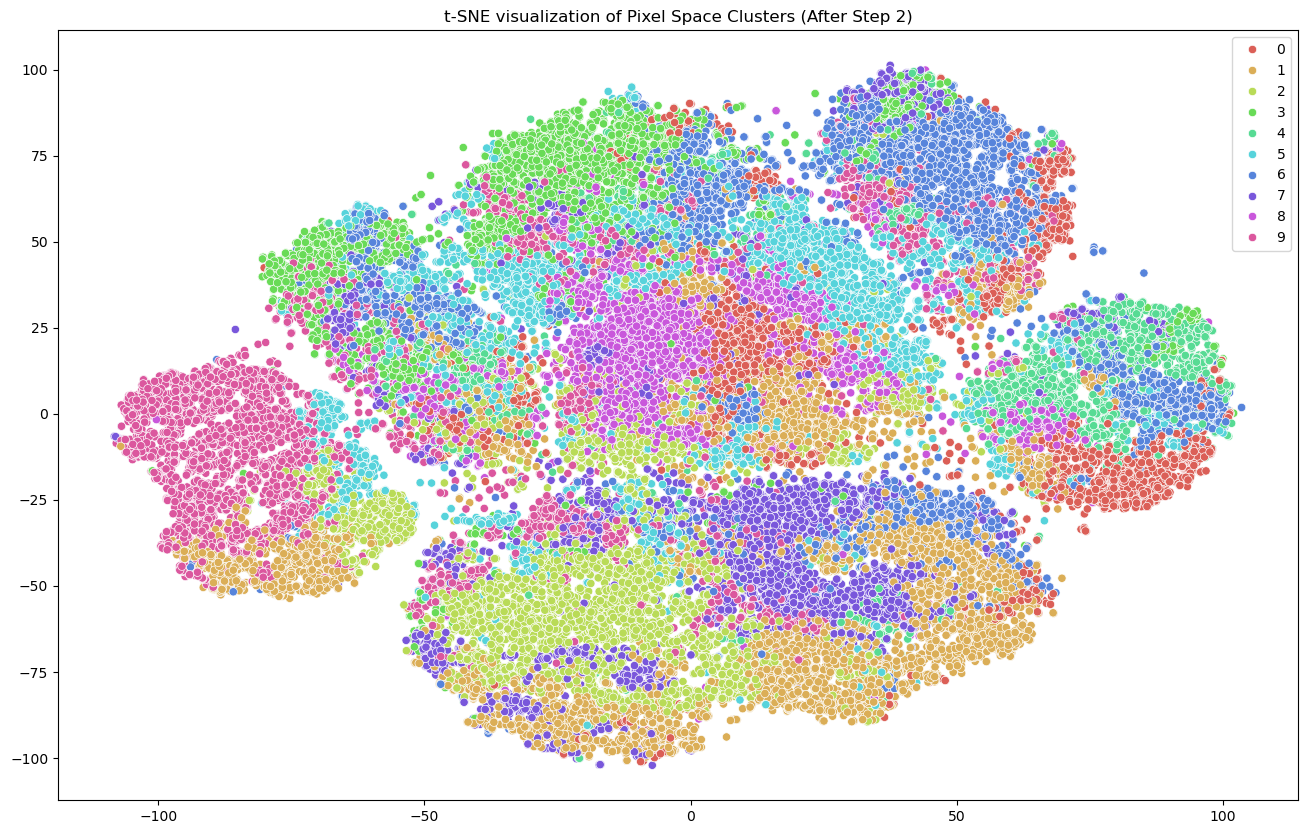

In [22]:
plt.figure(figsize=(16, 10))
sns.scatterplot(x=tsne_ae_results[:,0], y=tsne_ae_results[:,1], palette=sns.color_palette("hls", 10),hue=mnist_labels, legend="full")
plt.title("t-SNE visualization of Pixel Space Clusters (After Step 2)")
plt.show()

plt.figure(figsize=(16, 10))
sns.scatterplot(x=tsne_ae_results[:,0], y=tsne_ae_results[:,1], palette=sns.color_palette("hls", 10),hue=cluster_labels_latent, legend="full")
plt.title("t-SNE visualization of Pixel Space Clusters (After Step 2)")
plt.show()



# Experiment

There are a number of hyper-paramters
* How does the latent dim effect the clustering and reconstruction (try as small as 2 or as big 32)
* How does the L1 norm change the generation?

A smaller latent dimension improves clustering by enforcing a more structured latent space but may reduce reconstruction quality. Increasing the latent dimension enhances reconstruction fidelity but can make the latent space more complex and harder to cluster. Higher L1 regularization encourages sparsity, leading to cleaner generated images, while lower regularization improves reconstruction at the cost of potentially chaotic generation.

# 510 Experiment

Try some other clustering techniques that aren't k-means, do any give you a clustering that closely match the true labels? 


In [23]:
"Your answer here"

'Your answer here'